In [5]:
! pip install tsfresh

  Using cached tsfresh-0.20.2-py2.py3-none-any.whl.metadata (2.5 kB)
  Using cached stumpy-1.13.0-py3-none-any.whl.metadata (28 kB)
  Using cached cloudpickle-3.0.0-py3-none-any.whl.metadata (7.0 kB)
  Using cached numba-0.60.0-cp311-cp311-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (2.7 kB)
  Using cached llvmlite-0.43.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.8 kB)
Using cached tsfresh-0.20.2-py2.py3-none-any.whl (95 kB)
Using cached stumpy-1.13.0-py3-none-any.whl (176 kB)
Using cached cloudpickle-3.0.0-py3-none-any.whl (20 kB)
Using cached numba-0.60.0-cp311-cp311-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (3.7 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 MB 2.2 MB/s eta 0:00:0000:0100:01m


In [1]:
%load_ext autoreload
%autoreload 2

In [78]:
import pandas as pd
pd.options.mode.chained_assignment = None  # disabilita l'avviso
import sys
sys.path.append('..')
from tsfresh import select_features, extract_features
from tsfresh.feature_extraction import MinimalFCParameters, EfficientFCParameters, ComprehensiveFCParameters

from src.transformations.dataset import *
from src.transformations.features import *
from src.transformations.filters import *

In [123]:
file_path = '../dati/data_20240513_101632.csv'
df = pd.read_csv(
    file_path,
    header=6,
    sep=';',
)

In [127]:
dfs = df.pipe(csv_shift)\
        .pipe(split_sensors)

def preproc(df: pd.DataFrame) -> pd.DataFrame:
    df = df\
        .pipe(timestamp)\
        .dropna()\
        .pipe(drop_data_by_lower_bounds, cols=['OFFSET_s'], lower_bounds=[0.5])\
        .pipe(lowess_filter, num_fit=25, cols=['Ax', 'Ay','Az', 'Gx', 'Gy', 'Gz'])\
        .pipe(magnitudo, cols_xyz=[['Ax', 'Ay','Az']], names_magnitudo=['MAGNITUDO'])\
        .pipe(diff_dt, cols=['MAGNITUDO'])\
        .pipe(angle_beetwen_vectors, cols_xyz=[['Ax', 'Ay','Az']], angles_names=['THETA'])\
        .pipe(create_grouping_col_by_second, sec=0.5)\
        .pipe(keep_cols, cols=['TIMESTAMP', 'group_0.5_sec', 'MAGNITUDO', 'Ax', 'Ay', 'Az', 'Gx', 'Gy', 'Gz'])
    
    # tfresh part
    #     df = 
    return df

df_an = preproc(dfs['AN'])
df_an['group_0.5_sec'] = df_an['group_0.5_sec'].astype(str) + '_AN'
df_tm1 = preproc(dfs['TM1'])
df_tm1['group_0.5_sec'] = df_tm1['group_0.5_sec'].astype(str) + '_TM1'
df_tm2 = preproc(dfs['TM2'])
df_tm2['group_0.5_sec'] = df_tm2['group_0.5_sec'].astype(str) + '_TM2'
df_tr1 = preproc(dfs['TR1'])
df_tr1['group_0.5_sec'] = df_tr1['group_0.5_sec'].astype(str) + '_TR1'
df_tr2 = preproc(dfs['TR2'])
df_tr2['group_0.5_sec'] = df_tr2['group_0.5_sec'].astype(str) + '_TR2'


In [128]:
df_ = pd.concat([df_an, df_tm1, df_tm2, df_tr1, df_tr2])

In [129]:
df_

,TIMESTAMP,group_0.5_sec,MAGNITUDO,Ax,Ay,Az,Gx,Gy,Gz
0.506,2024-05-13 08:16:53.096,0_AN,1006.193825,246.718196,618.774706,754.104773,-1237.270221,-1297.832807,-248.149338
0.583,2024-05-13 08:16:53.173,0_AN,1006.480475,246.750175,617.561862,755.469817,-772.785785,-596.543299,-259.136338
0.613,2024-05-13 08:16:53.203,0_AN,1006.542128,246.652138,617.123425,755.942098,-590.493583,-330.956363,-263.493449
0.627,2024-05-13 08:16:53.217,0_AN,1006.563103,246.592924,616.930945,756.146426,-505.504320,-208.338114,-265.983521
0.666,2024-05-13 08:16:53.256,0_AN,1006.607512,246.405808,616.444814,756.662839,-270.062059,129.301551,-275.741786
...,...,...,...,...,...,...,...,...,...
363.751,2024-05-13 08:22:56.341,726_TR2,1549.994384,1227.170982,-938.445947,-125.909406,-70226.316665,134857.852402,54643.440179
363.775,2024-05-13 08:22:56.365,726_TR2,1611.247162,1261.812662,-996.357181,-105.917845,-88052.449904,162009.346358,73397.199792
363.789,2024-05-13 08:22:56.379,726_TR2,1647.535190,1281.970618,-1030.545393,-94.338382,-98437.699403,177871.814044,84416.620263
363.796,2024-05-13 08:22:56.386,726_TR2,1665.823457,1292.036644,-1047.742699,-88.568274,-103627.291734,185808.834722,89944.820717


In [130]:
features = extract_features(df_, column_sort="TIMESTAMP", column_id='group_0.5_sec')

Feature Extraction: 100%|██████████| 50/50 [03:33<00:00,  4.27s/it]


In [131]:
features

,Gy__variance_larger_than_standard_deviation,Gy__has_duplicate_max,Gy__has_duplicate_min,Gy__has_duplicate,Gy__sum_values,Gy__abs_energy,Gy__mean_abs_change,Gy__mean_change,Gy__mean_second_derivative_central,Gy__median,...,Gx__fourier_entropy__bins_5,Gx__fourier_entropy__bins_10,Gx__fourier_entropy__bins_100,Gx__permutation_entropy__dimension_3__tau_1,Gx__permutation_entropy__dimension_4__tau_1,Gx__permutation_entropy__dimension_5__tau_1,Gx__permutation_entropy__dimension_6__tau_1,Gx__permutation_entropy__dimension_7__tau_1,Gx__query_similarity_count__query_None__threshold_0.0,Gx__mean_n_absolute_max__number_of_maxima_7
0_AN,1.0,0.0,0.0,0.0,7917.183087,1.228896e+07,203.995095,60.948800,-23.185583,348.244093,...,0.600166,0.885574,0.885574,0.729843,0.885289,1.037392,1.172993,1.226556,NaN,805.731357
0_TM1,1.0,0.0,0.0,0.0,-2259.018354,3.221520e+05,15.327824,-5.400172,-1.535340,-86.797700,...,0.759547,0.885574,0.885574,0.786701,0.955447,1.127483,1.297296,1.450805,NaN,778.075475
0_TM2,1.0,0.0,0.0,0.0,2825.670333,6.501280e+05,29.922235,5.578625,2.192417,97.806323,...,0.304636,0.759547,0.885574,1.299870,1.568442,1.766690,1.968693,2.168223,NaN,1240.760680
0_TR1,1.0,0.0,0.0,0.0,8959.496701,1.057272e+07,145.280038,-67.229244,15.063063,308.147042,...,0.600166,0.885574,1.159589,1.087075,1.579233,2.014036,2.171571,2.242973,NaN,103.660264
0_TR2,1.0,0.0,0.0,0.0,6776.619777,4.386694e+06,81.056991,-21.688299,-6.415335,488.305755,...,0.759547,0.759547,0.759547,1.299870,1.568442,1.766690,1.968693,2.168223,NaN,629.531159
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9_AN,1.0,0.0,0.0,0.0,-25039.723616,3.730908e+07,160.290505,-14.275321,6.234362,-1119.420202,...,0.286836,0.566086,0.566086,0.501047,0.587501,0.609627,0.633663,0.659872,NaN,1460.562691
9_TM1,1.0,0.0,0.0,0.0,-14089.934936,1.025840e+07,38.627775,-37.546853,-0.587783,-468.805564,...,0.566086,0.566086,0.836988,1.471689,1.912304,2.205155,2.366289,2.507026,NaN,953.829528
9_TM2,1.0,0.0,0.0,0.0,-5290.723505,1.972947e+06,30.476653,-30.476653,0.491901,-219.809504,...,0.721464,0.836988,1.098612,0.832408,0.995821,1.166733,1.344693,1.528466,NaN,1541.185247
9_TR1,1.0,0.0,0.0,0.0,15863.325145,1.720089e+07,79.165568,-40.203241,-3.002231,600.666310,...,0.286836,0.286836,0.836988,0.567061,0.587501,0.609627,0.633663,0.659872,NaN,801.740310


In [87]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [116]:
features.min()

Ax__variance_larger_than_standard_deviation                         0.000000
Ax__has_duplicate_max                                               0.000000
Ax__has_duplicate_min                                               0.000000
Ax__has_duplicate                                                   0.000000
Ax__sum_values                                                 -28608.153146
                                                                    ...     
MAGNITUDO__permutation_entropy__dimension_5__tau_1                 -0.000000
MAGNITUDO__permutation_entropy__dimension_6__tau_1                 -0.000000
MAGNITUDO__permutation_entropy__dimension_7__tau_1                 -0.000000
MAGNITUDO__query_similarity_count__query_None__threshold_0.0             NaN
MAGNITUDO__mean_n_absolute_max__number_of_maxima_7                784.689881
Length: 5481, dtype: float64

<Axes: >

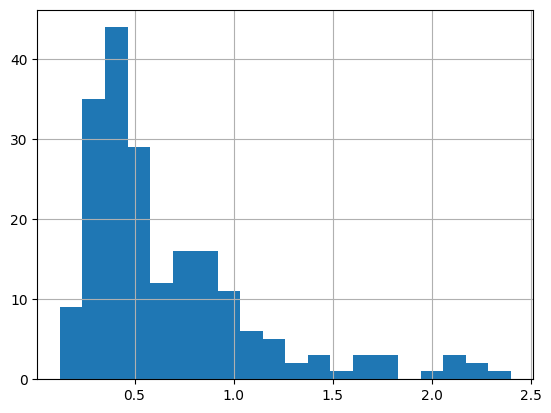

In [122]:
features.loc[~np.isinf(features['Az__sample_entropy']), 'Az__sample_entropy'].hist(bins=20)

In [121]:
inf = np.isinf(features).sum()
inf[inf > 0]
# (np.isinf(features).sum() > 0).

Ax__sample_entropy           19
Ay__sample_entropy           19
Az__sample_entropy           20
Gx__sample_entropy           11
Gy__sample_entropy           20
Gz__sample_entropy           11
MAGNITUDO__sample_entropy    19
dtype: int64

In [95]:
nans = features.isna().sum(axis=0)
features = features[nans[nans == 0].index.to_list()]
pca = PCA()
scaler = StandardScaler()
X = scaler.fit_transform(features)
X = pca.fit_transform(X)

ValueError: Input X contains infinity or a value too large for dtype('float64').

In [55]:
pca.explained_variance_ratio_.cumsum()

array([0.26137738, 0.42174293, 0.53889325, 0.61220568, 0.66851618,
       0.7125897 , 0.74398586, 0.77273388, 0.79403483, 0.81349793,
       0.83082587, 0.84633414, 0.86069901, 0.87188106, 0.88250206,
       0.8929762 , 0.90145748, 0.90981294, 0.91767799, 0.92455464,
       0.93136628, 0.9376265 , 0.94309053, 0.9485365 , 0.9537743 ,
       0.95847681, 0.96292012, 0.96705054, 0.97096424, 0.97443504,
       0.97769378, 0.98058888, 0.98328182, 0.98554131, 0.98766703,
       0.98972888, 0.99164632, 0.99334167, 0.99487036, 0.99617204,
       0.9973078 , 0.99838006, 0.99935368, 1.        , 1.        ])

In [56]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [57]:
X_tsne = TSNE(n_components=2, random_state=1926).fit_transform(X)

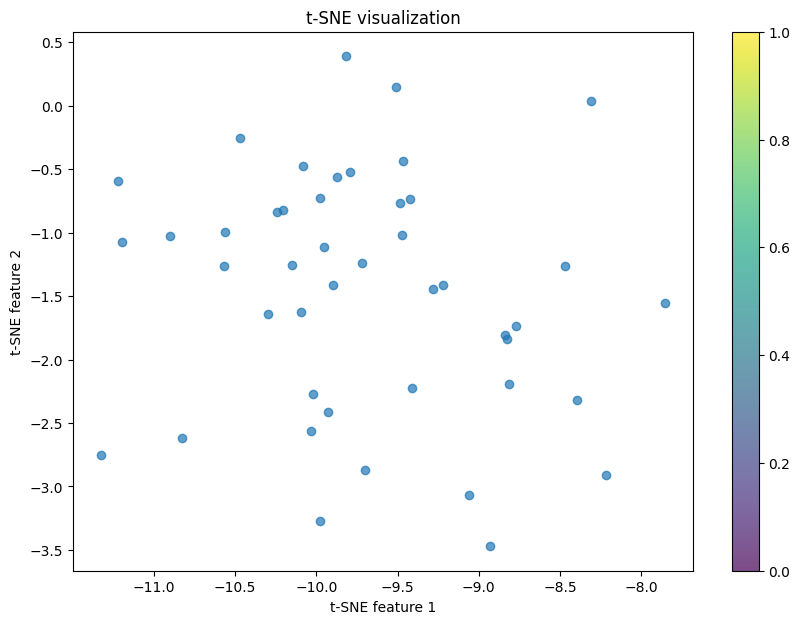

In [59]:
plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], alpha=0.7)
plt.colorbar(scatter)
plt.title('t-SNE visualization')
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.show()